In [1]:
import pandas as pd

In [2]:
pip install git+https://github.com/quantopian/pyfolio


  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio 'C:\Users\Shivam\AppData\Local\Temp\pip-req-build-qh6sfrsr'
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 1.15.4 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.21.6 which is incompatible.



  Cloning https://github.com/quantopian/pyfolio to c:\users\shivam\appdata\local\temp\pip-req-build-qh6sfrsr
  Resolved https://github.com/quantopian/pyfolio to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached numpy-1.21.6-cp37-cp37m-win_amd64.whl.metadata (2.2 kB)
Using cached numpy-1.21.6-cp37-cp37m-win_amd64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4


In [3]:
# import again if first time not work
import pyfolio

c:\Users\Shivam\AppData\Local\Programs\Python\Python37\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [4]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [5]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [6]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [41]:
df=pd.read_csv('data/dow_30_2009_2025.csv')

In [45]:
rebalance_window = 94
validation_window = 94
unique_trade_date = df[(df.datadate > 20190206)&(df.datadate < 20251001)].datadate.unique()

In [46]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [47]:
def get_account_value(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format(model_name,i))
        df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    df_account_value=df_account_value.join(df_trade_date[63:].reset_index(drop=True))
    return df_account_value

In [48]:
ensemble_account_value = get_account_value('ensemble')

0.36631005741014194


## DJIA

In [49]:
dji = pd.read_csv("data/^DJI.csv")
test_dji=dji[(dji['Date']>='2019-02-06') & (dji['Date']<='2025-08-31')]
test_dji = test_dji.reset_index(drop=True)

In [50]:
test_dji.shape

(1651, 7)

In [51]:
test_dji.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-02-06,25371.570313,25439.039063,25312.060547,25390.300781,25390.300781,247590000
1,2019-02-07,25265.810547,25314.259766,25000.519531,25169.529297,25169.529297,295460000
2,2019-02-08,25042.359375,25106.390625,24883.039063,25106.330078,25106.330078,248210000
3,2019-02-11,25142.810547,25196.750000,25009.099609,25053.109375,25053.109375,241700000
4,2019-02-12,25152.029297,25458.980469,25152.029297,25425.759766,25425.759766,278110000


In [52]:
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

In [53]:
dow_strat = backtest_strat(test_dji)

## Ensemble Strategy

In [88]:
ensemble_account_value.Date[0][2:]

'19-02-06'

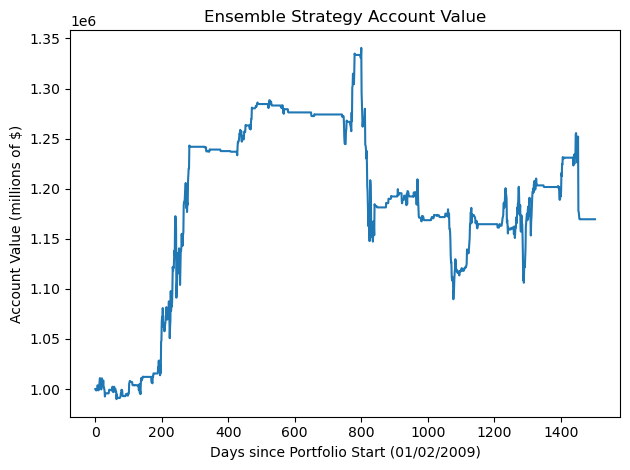

In [96]:
matplotlib.pyplot.plot(ensemble_account_value.account_value)
matplotlib.pyplot.xlabel('Days since Portfolio Start (01/02/2009)')
matplotlib.pyplot.ylabel('Account Value (millions of $)')
matplotlib.pyplot.title('Ensemble Strategy Account Value')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()


In [55]:
ensemble_account_value = get_daily_return(ensemble_account_value)

Sharpe:  0.36631005741014194


In [56]:
ensemble_account_value['Date'] = test_dji['Date']

In [57]:
ensemble_account_value.head()

,account_value,datadate,daily_return,Date
0,1000000.000000,20190509,NaN,2019-02-06
1,999173.785668,20190510,-0.000826,2019-02-07
2,998895.530840,20190513,-0.000278,2019-02-08
3,998613.141468,20190514,-0.000283,2019-02-11
4,998956.403594,20190515,0.000344,2019-02-12


In [61]:
ensemble_strat = backtest_strat(ensemble_account_value[0:1097])

In [62]:
ensemble_account_value.to_csv('results/df_account_value_ensemble_daily_return.csv',index=False)

Start date,2019-02-06
End date,2023-06-14
Total months,52
,Backtest
Annual return,2.589%
Cumulative returns,11.77%
Annual volatility,7.988%
Sharpe ratio,0.36
Calmar ratio,0.14
Stability,0.27
Max drawdown,-18.715%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.72,2022-04-08,2023-05-17,NaT,NaN
1,6.94,2020-01-22,2020-01-27,2020-02-27,27
2,3.40,2021-03-08,2022-01-28,2022-03-02,258
3,3.37,2019-12-20,2019-12-26,2019-12-31,8
4,2.40,2020-03-06,2020-03-12,2020-03-17,8


c:\Users\Shivam\AppData\Local\Programs\Python\Python37\lib\site-packages\pyfolio\tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


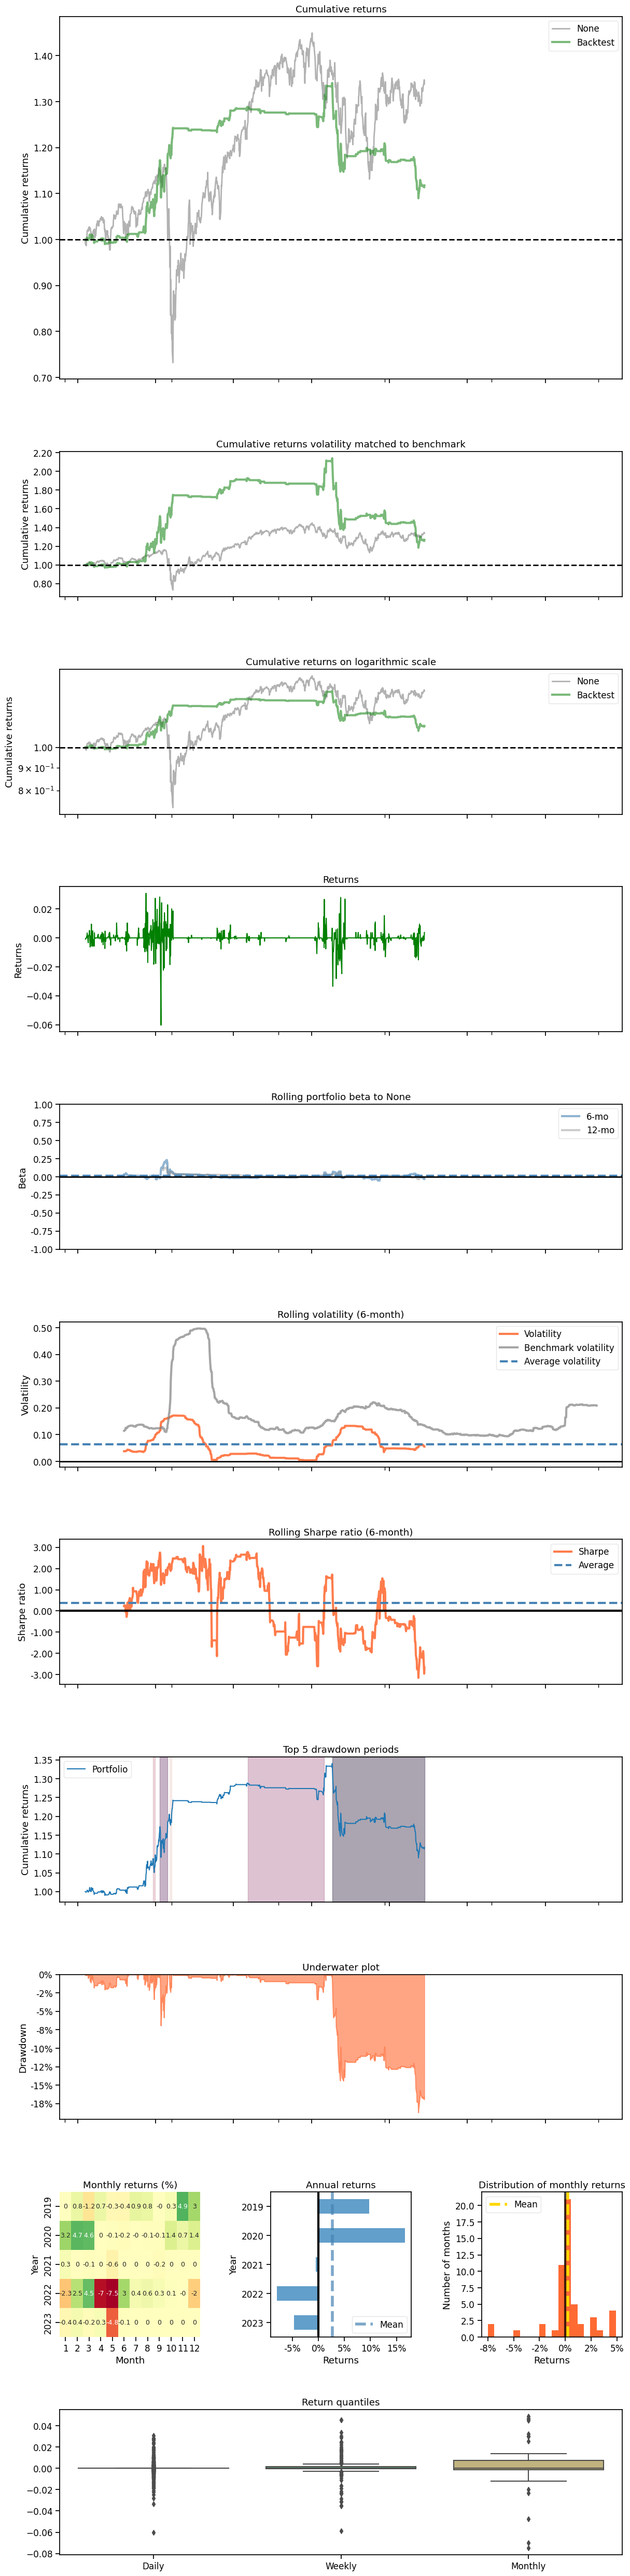

In [63]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat,
                                   benchmark_rets=dow_strat, set_context=False)